In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from collections import Counter 
from tqdm import tqdm
from random import seed, randint, choice

from swarm_sim import *

%matplotlib inline 

In [2]:
# 1st dataset: N=50
PATH = '..\\..\\data\\swarm-50-sats-scenario\\coords_v1_if_LLO-'
EXPORT_PATH = 'output\\data'
ROW_DATA = 7

NB_NODES = 50
DURATION = 8641 # Number of data rows, not time!
REVOLUTION = 1800 # Number of data rows
CONNECTION_RANGE = 30 # km

SAMPLE_STEP = 12


In [3]:
satellites = {} # Dict(sat_id: DataFrame)
with tqdm(total=NB_NODES, desc='Extracting data') as pbar:
    for i in range(NB_NODES):
        df_data = pd.read_csv(PATH+str(i)+'.csv', skiprows= lambda x: x<ROW_DATA, header=0)
        satellites[i] = df_data
        pbar.update(1)
        
swarm_data = {} # Dict{timestamp: Swarm}
with tqdm(total=REVOLUTION, desc='Converting to topologies') as pbar:
    for t in range(REVOLUTION):
        swarm_data[t] = Swarm(CONNECTION_RANGE,
                    nodes = [Node(id, sat['xF[km]'].iloc[t], sat['yF[km]'].iloc[t], sat['zF[km]'].iloc[t]) for id,sat in satellites.items()]
                    )
        pbar.update(1)

neighbor_matrices = {} # Dict{timestamp: matrix}
with tqdm(total=REVOLUTION, desc='Computing neighbor matrices') as pbar:
    for t in range(REVOLUTION):
        neighbor_matrices[t] = swarm_data[t].neighbor_matrix()
        pbar.update(1)

topo_graphs = {} # Dict{timestamp: Graph}
with tqdm(total=REVOLUTION, desc='Converting to NetworkX graphs') as pbar:
    for t in range(REVOLUTION):
        topo_graphs[t] = swarm_data[t].swarm_to_nxgraph()
        pbar.update(1)

Extracting data:   0%|          | 0/50 [00:00<?, ?it/s]

Converting to NetworkX graphs: 100%|██████████| 1800/1800 [00:07<00:00, 235.97it/s]


## Temporal evolution

We compute metrics on the orginial (undivided) graph, then re-compute them on the divided graph (see algos below). The comparison is performed with the variation coefficient (VC), which is the ratio of standard deviation to average.

Analysed metrics for comparison to the original graph (VC: the average value is that of the original graph):
- Average degree (AD): number of direct neighbor(s) for each node, averaged
- Average clustering coefficient (ACC): ratio of observed edges in the neighborhood over maximum possible number of edges, averaged
- Average betweenness centrality (ABC), normalized: number of shortest paths passing through a node, averaged

Analyzed metrics for comparison between algorithms (VC: the average value is NB_NODES/NB_GROUPS):
- Network size (NS): number of nodes per group

Implemented algorithms:
- Random Node Division (RND)
- Multiple Independent Random Walks (MIRW)
- Forest Fire Division (FFD)

In [6]:
# Reference temporal evolution: Average Degree, Graph Density, Average Clustering Coefficient
ref_ad, ref_acc, ref_abc = [], [], []

with tqdm(total=REVOLUTION/SAMPLE_STEP, desc='Reference metrics') as pbar:
    for t in np.arange(0, REVOLUTION, SAMPLE_STEP):
        graph = topo_graphs[t]
        ref_ad.append(np.mean(nx.degree(graph)))
        ref_acc.append(nx.average_clustering(graph))
        ref_abc.append(np.mean(list(nx.betweenness_centrality(graph).values())))
        pbar.update(1)

Reference metrics:   0%|          | 0/150.0 [00:00<?, ?it/s]

Reference metrics: 100%|██████████| 150/150.0 [00:01<00:00, 87.50it/s] 


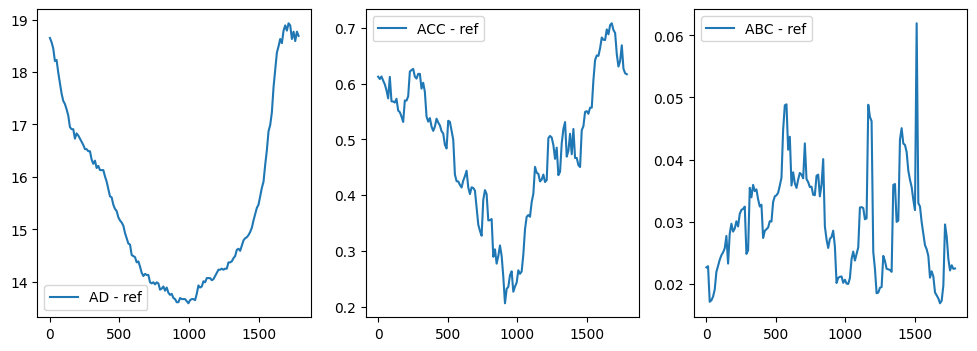

In [7]:
fig, axes = plt.subplots(ncols=3, figsize=(12,4))
idx = np.arange(0, REVOLUTION, SAMPLE_STEP)

ax = axes[0]
ax.plot(idx, ref_ad, label='AD - ref')
ax.legend()

ax = axes[1]
ax.plot(idx, ref_acc, label='ACC - ref')
ax.legend()

ax = axes[2]
ax.plot(idx, ref_abc, label='ABC - ref')
ax.legend()

In [8]:
def variance(data, mean=None):
    if mean == None:
        mean = np.mean(data)
    return np.mean([(d - mean)**2 for d in data])

def variation_coef(data, mean=None):
    if mean != 0:
        var = variance(data, mean)
        return np.sqrt(var)/mean
    print('Error: mean is null.')
    return -1

In [26]:
NB_GROUPS = 10
NB_REPETITIONS = 30

## 1. Random Node Division

In [27]:
algo = 'RND' # <==================== ALGO CHOICE 
print('\nPerforming graph division:', algo, '\t\tNumber of repetitions:', NB_REPETITIONS)

varcoef_dict = {
    'Timestamp':[],
    'VC AD':[],
    'VC ACC':[],
    'VC ABC':[]
}


for rep in range(NB_REPETITIONS):
    swarm_data[0].reset_groups()
    groups = swarm_data[0].RND(n=NB_GROUPS, s=rep+1, by_id=True)# <==================== ALGO CHOICE 

    group_assignment = {}
    for node in swarm_data[0].nodes:
        group_assignment[node.id] = node.group
    
    with tqdm(total=REVOLUTION/SAMPLE_STEP, desc='Varcoef computation '+str(rep)) as pbar:
        for t in np.arange(0, REVOLUTION, SAMPLE_STEP):
            graph = topo_graphs[t]

            group_ad = [] # List(mean degree of group)
            group_acc = []
            group_abc = []

            for group_id, node_list in groups.items():
                if len(node_list)>0:
                    group_ad.append(np.mean(nx.degree(graph, node_list)))
                    group_acc.append(nx.average_clustering(graph, node_list))
                    bc_dict = nx.betweenness_centrality(graph)
                    group_abc.append(np.mean([bc_dict[i] for i in node_list]))
                
            vc_ad = variation_coef(group_ad, ref_ad[int(t/SAMPLE_STEP)]) 
            vc_acc = variation_coef(group_acc, ref_acc[int(t/SAMPLE_STEP)]) 
            vc_abc = variation_coef(group_abc, ref_abc[int(t/SAMPLE_STEP)]) 
            
            varcoef_dict['Timestamp'].append(t)
            varcoef_dict['VC AD'].append(vc_ad)
            varcoef_dict['VC ACC'].append(vc_acc)
            varcoef_dict['VC ABC'].append(vc_abc)
            
            pbar.update(1)


Performing graph division: RND 		Number of repetitions: 30


Varcoef computation 0: 100%|██████████| 150/150.0 [00:09<00:00, 16.36it/s]
Varcoef computation 1: 100%|██████████| 150/150.0 [00:11<00:00, 13.15it/s]
Varcoef computation 2: 100%|██████████| 150/150.0 [00:11<00:00, 13.40it/s]
Varcoef computation 3: 100%|██████████| 150/150.0 [00:10<00:00, 14.56it/s]
Varcoef computation 4: 100%|██████████| 150/150.0 [00:09<00:00, 15.23it/s]
Varcoef computation 5: 100%|██████████| 150/150.0 [00:10<00:00, 14.40it/s]
Varcoef computation 6: 100%|██████████| 150/150.0 [00:09<00:00, 15.12it/s]
Varcoef computation 7: 100%|██████████| 150/150.0 [00:09<00:00, 15.02it/s]
Varcoef computation 8: 100%|██████████| 150/150.0 [00:10<00:00, 14.70it/s]
Varcoef computation 9: 100%|██████████| 150/150.0 [00:10<00:00, 14.39it/s]
Varcoef computation 10: 100%|██████████| 150/150.0 [00:18<00:00,  8.28it/s]
Varcoef computation 11: 100%|██████████| 150/150.0 [00:14<00:00, 10.26it/s]
Varcoef computation 12: 100%|██████████| 150/150.0 [00:13<00:00, 11.11it/s]
Varcoef computation 13

In [28]:
df = pd.DataFrame(varcoef_dict)
df = df.groupby('Timestamp').mean()
df

,VC AD,VC ACC,VC ABC
Timestamp,,,
0,0.224004,0.156661,0.436727
12,0.226643,0.159175,0.407311
24,0.227775,0.185817,0.449370
36,0.230439,0.184010,0.490126
48,0.227582,0.190153,0.496867
...,...,...,...
1740,0.213459,0.139190,0.513610
1752,0.212395,0.120128,0.588571
1764,0.216236,0.144540,0.534180


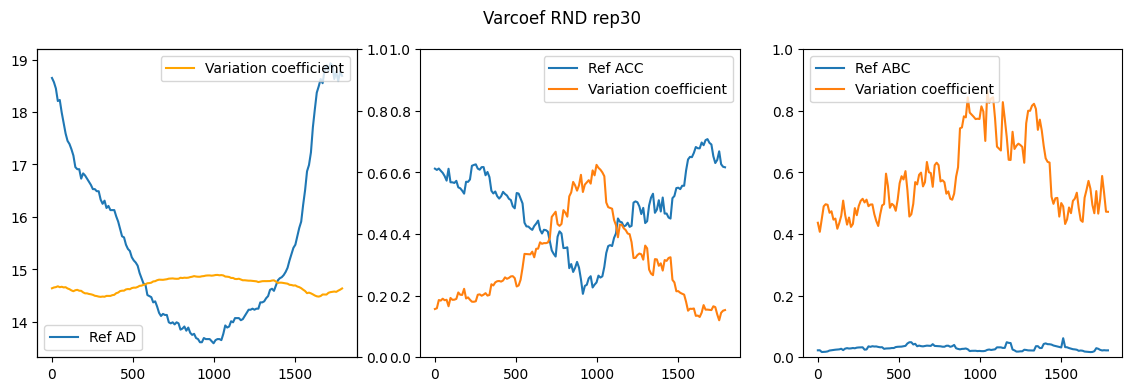

In [30]:
fig, axes = plt.subplots(figsize=(14,4), ncols=3)
fig.suptitle('Varcoef RND rep30')

ax = axes[0]
ax.plot(idx, ref_ad, label='Ref AD')
ax.legend()
ax2 = ax.twinx()
ax2.plot(idx, df['VC AD'], c='orange', label='Variation coefficient')
ax2.tick_params(axis='y', labelcolor='black')
ax2.set_ylim(0,1)
ax2.legend()

ax = axes[1]
ax.plot(idx, ref_acc, label='Ref ACC')
ax.plot(idx, df['VC ACC'], label='Variation coefficient')
ax.set_ylim(0,1)
ax.legend()

ax = axes[2]
ax.plot(idx, ref_abc, label='Ref ABC')
ax.plot(idx, df['VC ABC'], label='Variation coefficient')
ax.set_ylim(0,1)
ax.legend()